In [1]:
import os
os.chdir('C:\\Users\\Takanori\\Desktop\\Kaggle\\TPS2205\\input')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torchviz import make_dot

In [4]:
# データセット読み込み
train = pd.read_csv("../input/tabular-playground-series-may-2022/train.csv", index_col='id')
test = pd.read_csv("../input/tabular-playground-series-may-2022/test.csv", index_col='id')
sub = pd.read_csv("../input/tabular-playground-series-may-2022/sample_submission.csv")
display(train.head())
display(test.head())
display(sub.head())

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
id,,,,,,,,,,,,,,,,,,,,,
0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,1,...,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,4,...,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1
2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,2,...,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,AAAEABCKAD,-195.599702,0,2,1
3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,1,...,0.572594,-1.653213,1.686035,-2.533098,-0.608601,BDBBAACBCB,210.826205,0,0,1
4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,0,...,-3.912929,-1.430366,2.127649,-3.306784,4.371371,BDBCBBCHFE,-217.211798,0,1,1


,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30
id,,,,,,,,,,,,,,,,,,,,,
900000,0.442517,0.174380,-0.999816,0.762741,0.186778,-1.074775,0.501888,6,6,0,...,-1.006400,-1.193879,-2.435736,-2.427430,-1.966887,5.734205,BAAABADLAC,99.478419,0,0
900001,-0.605598,-0.305715,0.627667,-0.578898,-1.750931,1.355550,-0.190911,1,3,4,...,2.382405,0.149442,1.883322,-2.848714,-0.725155,3.194219,AFABBAEGCB,-65.993825,1,0
900002,0.303990,2.445110,0.246515,0.818248,0.359731,-1.331845,1.358622,3,3,4,...,-7.026098,1.312277,-5.157192,1.714005,0.585032,0.066898,BBACABBKEE,-87.405622,0,1
900003,0.154053,0.260126,-1.367092,-0.093175,-1.111034,-0.948481,1.119220,0,0,4,...,-0.594532,-3.939475,1.754570,-2.364007,-1.003320,3.893099,AEBEAACQCC,-281.293460,0,0
900004,-1.651904,-0.424266,-0.667356,-0.322124,-0.089462,0.181705,1.784983,2,2,2,...,0.084906,-0.985736,-0.130467,-3.557893,1.210687,1.861884,AEBBBBDABF,25.629415,0,2


,id,target
0,900000,0.5
1,900001,0.5
2,900002,0.5
3,900003,0.5
4,900004,0.5


In [5]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [6]:
train = train.drop('f_27', axis=1)
test = test.drop('f_27', axis=1)

In [7]:
X_train = torch.tensor(train.drop('target', axis=1).values).float()
y_train = torch.tensor(train['target']).float()
y_train = y_train.view((-1,1))

In [8]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [9]:
X_train.to(device)
y_train.to(device)

tensor([[0.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [1.]])

In [10]:
X_train.shape

torch.Size([900000, 30])

In [11]:
class Net(nn.Module):
    def __init__(self, n_features, n_hidden1, n_hidden2, n_output):
        super().__init__()
        self.fc1 = nn.Linear(n_features, n_hidden1)
        self.fc2 = nn.Linear(n_hidden1, n_hidden2)
        self.fc3 = nn.Linear(n_hidden2, n_hidden2)
        self.fc4 = nn.Linear(n_hidden2, n_output)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [12]:
model = Net(X_train.shape[1], 256, 8, 1)
model.to(device)
print(model)

Net(
  (fc1): Linear(in_features=30, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [13]:
# 損失関数
criterion = nn.BCEWithLogitsLoss()

# 最適化関数
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

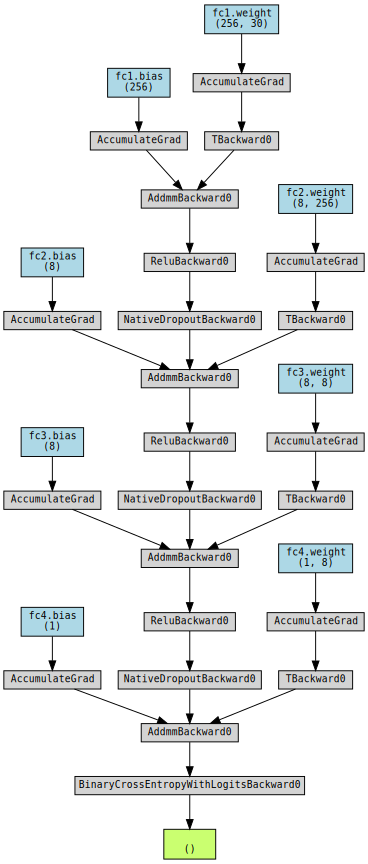

In [14]:
# 予測計算
outputs = model(X_train)

# 損失計算
loss = criterion(outputs, y_train)

# 損失の計算グラフ可視化
g = make_dot(loss, params=dict(model.named_parameters()))
display(g)

In [30]:
batch_size = 640
n_epochs = 200
batch_no = len(X_train) // batch_size

train_loss_min = np.Inf

for epoch in range(n_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_loss = loss.item()
    if train_loss < train_loss_min:
        print("Validation loss decreased ({:6f} ===> {:6f}). Saving the model...".format(train_loss_min,train_loss))
        torch.save(model.state_dict(), "model.pt")
        train_loss_min = train_loss
    if epoch % 200 == 0:
        print('Epoch {}: train_loss = {:.6f}'.format(epoch, train_loss))

print('Training Ended! ')

tensor(-2.1372, grad_fn=<MinBackward1>) tensor(3.5959, grad_fn=<MaxBackward1>)
Validation loss decreased (   inf ===> 0.692832). Saving the model...
Epoch 0: train_loss = 0.692832
tensor(-2.0464, grad_fn=<MinBackward1>) tensor(3.8753, grad_fn=<MaxBackward1>)
tensor(-2.7282, grad_fn=<MinBackward1>) tensor(3.5238, grad_fn=<MaxBackward1>)
tensor(-3.3414, grad_fn=<MinBackward1>) tensor(2.8927, grad_fn=<MaxBackward1>)
tensor(-3.3841, grad_fn=<MinBackward1>) tensor(3.3304, grad_fn=<MaxBackward1>)
Validation loss decreased (0.692832 ===> 0.692804). Saving the model...
tensor(-2.7042, grad_fn=<MinBackward1>) tensor(3.3290, grad_fn=<MaxBackward1>)
tensor(-2.1207, grad_fn=<MinBackward1>) tensor(5.0826, grad_fn=<MaxBackward1>)
tensor(-2.1593, grad_fn=<MinBackward1>) tensor(2.7520, grad_fn=<MaxBackward1>)
tensor(-2.1647, grad_fn=<MinBackward1>) tensor(4.0700, grad_fn=<MaxBackward1>)
tensor(-2.3700, grad_fn=<MinBackward1>) tensor(6.4080, grad_fn=<MaxBackward1>)
Validation loss decreased (0.692804 =

In [56]:
X_test = torch.tensor(test.values, requires_grad=False).float()
with torch.no_grad():
    pred = model(X_test)


In [57]:
pred.mean()

tensor(-0.0467)

In [58]:
pred = F.sigmoid(pred)

C:\Users\Takanori\MiniConda3\envs\yourenvname\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [59]:
pred.mean()

tensor(0.4882)

In [60]:
result_cpu = pred.cpu().numpy()

In [61]:
result_cpu.max()

0.93615586

In [62]:
result_cpu.min()

0.09234631

In [63]:
result_cpu.mean()

0.48820817

In [64]:
result_cpu = (result_cpu > result_cpu.mean()).astype(int)

In [65]:
sub['target'] = result_cpu

In [66]:
result_cpu.mean()

0.3314114285714286

In [67]:
sub.to_csv('submission.csv', index=False)
sub

,id,target
0,900000,0
1,900001,1
2,900002,0
3,900003,0
4,900004,0
...,...,...
699995,1599995,0
699996,1599996,0
699997,1599997,0
699998,1599998,0
